# Implement and train a LSTM for sentiment analysis


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Step 0: set up the environment

In [ ]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

nltk.download('stopwords')

# torch.backends.cudnn.benchmark = True

import os
os.makedirs("resources", exist_ok=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Hyperparameters. Do not directly touch this to mess up settings.

If you want to initalize new hyperparameter sets, use "new_hparams = HyperParams()" and change corresponding fields.

In [ ]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.PAD_INDEX = 0
        self.UNK_INDEX = 1
        self.PAD_TOKEN = '<pad>'
        self.UNK_TOKEN = '<unk>'
        self.STOP_WORDS = set(stopwords.words('english'))
        self.MAX_LENGTH = 256
        self.BATCH_SIZE = 96
        self.EMBEDDING_DIM = 1
        self.HIDDEN_DIM = 100
        self.OUTPUT_DIM = 2
        self.N_LAYERS = 1
        self.DROPOUT_RATE = 0.0
        self.LR = 0.01
        self.N_EPOCHS = 5
        self.WD = 0
        self.OPTIM = "sgd"
        self.BIDIRECTIONAL = False
        self.SEED = 2

## Lab 1(a) Implement your own data loader function.  
First, you need to read the data from the dataset file on the local disk. 
Then, split the dataset into three sets: train, validation and test by 7:1:2 ratio.
Finally return x_train, x_valid, x_test, y_train, y_valid, y_test where x represents reviews and y represent labels.  

In [ ]:
def load_imdb(base_csv:str = '/content/drive/MyDrive/Duke/2022-2023/ECE 661/HW3/HW3 Code/IMDBDataset.csv'):
    # Load the IMDB dataset
    # param base_csv: the path of the dataset file.
    # return: train, validation and test set.
    
    # Add your code here. 
    # load the data, separate into reviews (data) and sentiments (labels)
    data = pd.read_csv(base_csv)
    # extract just the values, pd dataframes include indices
    x = data['review'].values
    y = data['sentiment'].values
    
    # split the data into 7:1:2 (35000 validation, 5000 validation, 10000 test)
    # first split into 8:2 training and validation, test
    x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
    # then split the training and validation into 7:8 training, validation
    x_train, x_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, train_size=0.875, test_size=0.125)

    print(f'shape of train data is {x_train.shape}')
    print(f'shape of test data is {x_test.shape}')
    print(f'shape of valid data is {x_valid.shape}')
    return x_train, x_valid, x_test, y_train, y_valid, y_test

## Lab 1(b): Implement your function to build a vocabulary based on the training corpus.
Implement the build_vocab function to build a vocabulary based on the training corpus.
You should first compute the frequency of all the words in the training corpus. Remove the words
that are in the STOP_WORDS. Then filter the words by their frequency (≥ min_freq) and finally
generate a corpus variable that contains a list of words.

In [ ]:
def build_vocab(x_train:list, min_freq: int=5, hparams=None) -> dict:
    # build a vocabulary based on the training corpus.
    # param x_train:  List. The training corpus. Each sample in the list is a string of text.
    # param min_freq: Int. The frequency threshold for selecting words.
    # return: dictionary {word:index}
    
    # Add your code here. Your code should assign corpus with a list of words.
    corpus = {} # placeholder dictionary
    for review in x_train:
      for word in review.lower().split(): # standardize all words to lowercase 
        # each list item is a review
        # for each word in each review, as long as the word isn't in STOP_WORDS, add or increment word and its frequency
        if not(word in hparams.STOP_WORDS):
          # if the word isn't in the corpus yet, add it and set its frequency to 0
          if not(word in corpus.keys()):
            corpus[word] = 0
          # increment the word's frequency
          corpus[word] += 1

    # removing words if they occur less than min_freq times
    corpus_ = [word for word, freq in corpus.items() if freq >= min_freq]
    # sorting on the basis of most common words
    corpus_ = sorted(corpus_, key=corpus.get, reverse=True) # is this needed???
    # creating a dict
    vocab = {w:i+2 for i, w in enumerate(corpus_)}
    vocab[hparams.PAD_TOKEN] = hparams.PAD_INDEX
    vocab[hparams.UNK_TOKEN] = hparams.UNK_INDEX
    return vocab


## Lab 1(c): Implement your tokenize function. 
For each word, find its index in the vocabulary. 
Return a list of int that represents the indices of words in the example. 

In [ ]:
def tokenize(vocab: dict, example: str)-> list:
    # Tokenize the give example string into a list of token indices.
    # param vocab: dict, the vocabulary.
    # param example: a string of text.
    # return: a list of token indices.
    
    # Your code here.
    tokens = []
    # split the example string into words, for each word find the index in the vocab dict
    for word in example.lower().split(): # again, standardize all words to lowercase
      if word in vocab.keys(): # don't tokenize a word that isn't in the vocab (stopwords)
        tokens.append(vocab[word])
    return tokens

## Lab 1 (d): Implement the __getitem__ function. Given an index i, you should return the i-th review and label. 
The review is originally a string. Please tokenize it into a sequence of token indices. 
Use the max_length parameter to truncate the sequence so that it contains at most max_length tokens. 
Convert the label string ('positive'/'negative') to a binary index. 'positive' is 1 and 'negative' is 0. 
Return a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label. 

In [ ]:
class IMDB(Dataset):
    def __init__(self, x, y, vocab, max_length=256) -> None:
        # param x: list of reviews
        # param y: list of labels
        # param vocab: vocabulary dictionary {word:index}.
        # param max_length: the maximum sequence length.
        
        self.x = x
        self.y = y
        self.vocab = vocab
        self.max_length = max_length

    def __getitem__(self, idx: int):
        # Return the tokenized review and label by the given index.
        # param idx: index of the sample.
        # return: a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label.
        
        # Add your code here.
        # tokenize the string, shorten it to <=max_length
        tokens = tokenize(self.vocab, self.x[idx])
        tokens = tokens[:self.max_length]

        # if the sentiment is positive, label 1, if negative label 0
        sentiment = 0
        if (self.y[idx] == 'positive'):
          sentiment = 1
        else:
          sentiment = 0
        # create a dictionary with the information needed
        info = {'ids':tokens,
                'length':len(tokens), # should this be the length of the truncated sequence or the original length??
                'label':sentiment}
        return info 
        
    

    def __len__(self) -> int:
        return len(self.x)

def collate(batch, pad_index):
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = torch.Tensor([i['length'] for i in batch])
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'ids': batch_ids, 'length': batch_length, 'label': batch_label}
    return batch

collate_fn = collate

## Lab 1 (e): Implement the LSTM model for sentiment analysis.
Q(a): Implement the initialization function.
Your task is to create the model by stacking several necessary layers including an embedding layer, a lstm cell, a linear layer, and a dropout layer.
You can call functions from Pytorch's nn library. For example, nn.Embedding, nn.LSTM, nn.Linear.<br>
Q(b): Implement the forward function.
    Decide where to apply dropout. 
    The sequences in the batch have different lengths. Write/call a function to pad the sequences into the same length. 
    Apply a fully-connected (fc) layer to the output of the LSTM layer. 
    Return the output features which is of size [batch size, output dim]. 

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)
                
class LSTM(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        embedding_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        n_layers: int, 
        dropout_rate: float, 
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        
        # Create a LSTM model for classification.
        # :param vocab_size: size of the vocabulary
        # :param embedding_dim: dimension of embeddings
        # :param hidden_dim: dimension of hidden features
        # :param output_dim: dimension of the output layer which equals to the number of labels.
        # :param n_layers: number of layers.
        # :param dropout_rate: dropout rate.
        # :param pad_index: index of the padding token.we
        
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_index)
        # is a separate nn.Dropout module needed or is the built-in dropout fine?
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim) 

        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        # Feed the given token ids to the model.
        # :param ids: [batch size, seq len] batch of token ids.
        # :param length: [batch size] batch of length of the token ids.
        # :return: prediction of size [batch size, output dim].
        
        # Add your code here.
        prediction = self.embed(ids)
        # pack embeddings before passing to LSTM
        prediction = nn.utils.rnn.pack_padded_sequence(prediction, length, batch_first=True, enforce_sorted=False)
        # extract the final hidden state
        prediction = self.lstm(prediction)[1][0][-1]
        # flatten and pass to FC layer
        prediction = prediction.view(prediction.size(0), -1)
        prediction = self.fc(prediction)
        return prediction

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train(dataloader, model, criterion, optimizer, scheduler, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        scheduler.step()

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def predict_sentiment(text, model, vocab, device):
    tokens = tokenize(vocab, text)
    ids = [vocab[t] if t in vocab else UNK_INDEX for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

### Lab 1 (g) Implement GRU.

In [ ]:
class GRU(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        embedding_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        n_layers: int, 
        dropout_rate: float, 
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        
        # Create a LSTM model for classification.
        # :param vocab_size: size of the vocabulary
        # :param embedding_dim: dimension of embeddings
        # :param hidden_dim: dimension of hidden features
        # :param output_dim: dimension of the output layer which equals to the number of labels.
        # :param n_layers: number of layers.
        # :param dropout_rate: dropout rate.
        # :param pad_index: index of the padding token.we
        
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_index)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        # Weight Initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        # Feed the given token ids to the model.
        # :param ids: [batch size, seq len] batch of token ids.
        # :param length: [batch size] batch of length of the token ids.
        # :return: prediction of size [batch size, output dim].
        
        # Add your code here.
        prediction = self.embed(ids)
        prediction = nn.utils.rnn.pack_padded_sequence(prediction, length, batch_first=True, enforce_sorted=False)
        prediction = self.gru(prediction)[1][-1]
        prediction = torch.flatten(prediction, 1)
        prediction = self.fc(prediction)
        
        return prediction

### Learning rate warmup. DO NOT TOUCH!

In [ ]:
class ConstantWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps: int,
    ):
        self.num_warmup_steps = num_warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - self._step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            lr = self.base_lrs
        return lr

### Implement the training / validation iteration here.

In [ ]:
def train_and_test_model_with_hparams(hparams, model_type="lstm", **kwargs):
    # Seeding. DO NOT TOUCH! DO NOT TOUCH hparams.SEED!
    # Set the random seeds.
    torch.manual_seed(hparams.SEED)
    random.seed(hparams.SEED)
    np.random.seed(hparams.SEED)

    x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()
    vocab = build_vocab(x_train, hparams=hparams)
    vocab_size = len(vocab)
    print(f'Length of vocabulary is {vocab_size}')

    train_data = IMDB(x_train, y_train, vocab, hparams.MAX_LENGTH)
    valid_data = IMDB(x_valid, y_valid, vocab, hparams.MAX_LENGTH)
    test_data = IMDB(x_test, y_test, vocab, hparams.MAX_LENGTH)

    collate = functools.partial(collate_fn, pad_index=hparams.PAD_INDEX)

    train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(
        valid_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    test_dataloader = torch.utils.data.DataLoader(
        test_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    
    # Model
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
        model = GRU(
            vocab_size, 
            hparams.EMBEDDING_DIM, 
            hparams.HIDDEN_DIM, 
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE, 
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    else:
        model = LSTM(
            vocab_size, 
            hparams.EMBEDDING_DIM, 
            hparams.HIDDEN_DIM, 
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE, 
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    num_params = count_parameters(model)
    print(f'The model has {num_params:,} trainable parameters')


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Optimization. Lab 2 (a)(b) should choose one of them.
    # DO NOT TOUCH optimizer-specific hyperparameters! (e.g., eps, momentum)
    # DO NOT change optimizer implementations!
    if hparams.OPTIM == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, momentum=.9)        
    elif hparams.OPTIM == "adagrad":
        optimizer = optim.Adagrad(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "adam":
        optimizer = optim.Adam(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "rmsprop":
        optimizer = optim.RMSprop(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6, momentum=.9)
    else:
        raise NotImplementedError("Optimizer not implemented!")

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    # Start training
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    # Warmup Scheduler. DO NOT TOUCH!
    WARMUP_STEPS = 200
    lr_scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

    for epoch in range(hparams.N_EPOCHS):
        
        # Your code: implement the training process and save the best model.
        
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, lr_scheduler, device)
        valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)
        epoch_valid_loss = np.mean(valid_loss)
        epoch_valid_acc = np.mean(valid_acc)

        # Save the model that achieves the smallest validation loss.
        if epoch_valid_loss < best_valid_loss:
            # Your code: save the best model somewhere (no need to submit it to Sakai)
            best_valid_loss = epoch_valid_loss
            if not os.path.exists('./saved_model'):
              os.makedirs('./saved_model')
            print('Saving... ')
            state = {'state_dict':model.state_dict(),
                     'epoch':epoch,
                     'lr':lr_scheduler.get_lr()}
            torch.save(state, os.path.join('./saved_model', 'RNN.pth'))

        print(f'epoch: {epoch+1}')
        print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
        print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')


    # Your Code: Load the best model's weights.
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
      model = GRU(vocab_size, 
            hparams.EMBEDDING_DIM, 
            hparams.HIDDEN_DIM, 
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE, 
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    else:
      model = LSTM(vocab_size, 
            hparams.EMBEDDING_DIM, 
            hparams.HIDDEN_DIM, 
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE, 
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    state_dict = torch.load('./saved_model/RNN.pth')
    model.load_state_dict(state_dict['state_dict'])
    model.to(device)

    # Your Code: evaluate test loss on testing dataset (NOT Validation)
    test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = np.mean(test_acc)
    print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')
    
    # Free memory for later usage.
    del model
    torch.cuda.empty_cache()
    return {
        'num_params': num_params,
        "test_loss": epoch_test_loss,
        "test_acc": epoch_test_acc,
    }

### Lab 1 (f): Train model with original hyperparameters, for LSTM.

Train the model with default hyperparameter settings.

In [ ]:
org_hyperparams = HyperParams()
_ = train_and_test_model_with_hparams(org_hyperparams, "lstm_1layer_base_sgd_e32_h100")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 97,860 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.93it/s]
Saving... 
epoch: 1
train_loss: 0.693, train_acc: 0.497
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 83.65it/s]
epoch: 2
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.89it/s]
epoch: 3
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.81it/s]
Saving... 
epoch: 4
train_loss: 0.693, train_acc: 0.498
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.47it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.694, valid_acc: 0.498
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 86.50it/s]
test_loss: 0.693, test_acc:

### Lab 1 (h) Train GRU with vanilla hyperparameters.

In [ ]:
org_hyperparams = HyperParams()
_ = train_and_test_model_with_hparams(org_hyperparams, "gru_1layer_base_sgd_e32_h100", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 87,560 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.01it/s]
Saving... 
epoch: 1
train_loss: 0.694, train_acc: 0.498
valid_loss: 0.694, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 82.23it/s]
Saving... 
epoch: 2
train_loss: 0.694, train_acc: 0.495
valid_loss: 0.693, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.50it/s]
Saving... 
epoch: 3
train_loss: 0.694, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.21it/s]
Saving... 
epoch: 4
train_loss: 0.694, train_acc: 0.496
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.39it/s]
epoch: 5
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.498
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 87.05it/s]
test_

Text(0.5, 1.0, 'GRU Training Curve with Vanilla Hyperparameters')

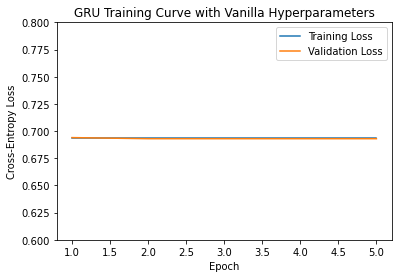

In [ ]:
train_losses = [0.694,0.694,0.694,0.694,0.694]
valid_losses = [0.694,0.693,0.693,0.693,0.693]
plt.plot(np.arange(1,6), train_losses, label='Training Loss')
plt.plot(np.arange(1,6), valid_losses, label='Validation Loss')
plt.legend()
plt.ylim(0.6,.8)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title("GRU Training Curve with Vanilla Hyperparameters")

### Lab 2 (a) Study of LSTM Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adagrad'
new_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(new_hparams, "lstm_1layer_adagrad")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 97,860 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.79it/s]
Saving... 
epoch: 1
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.507
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.06it/s]
Saving... 
epoch: 2
train_loss: 0.644, train_acc: 0.670
valid_loss: 0.570, valid_acc: 0.795
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.47it/s]
Saving... 
epoch: 3
train_loss: 0.538, train_acc: 0.813
valid_loss: 0.538, valid_acc: 0.817
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.45it/s]
Saving... 
epoch: 4
train_loss: 0.495, train_acc: 0.839
valid_loss: 0.524, valid_acc: 0.827
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.35it/s]
Saving... 
epoch: 5
train_loss: 0.463, train_acc: 0.853
valid_loss: 0.513, valid_acc: 0.832
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 85.81

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adagrad'
_ = train_and_test_model_with_hparams(new_hparams, "lstm_1layer_adagrad_lr_01")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 97,860 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.51it/s]
Saving... 
epoch: 1
train_loss: 0.682, train_acc: 0.602
valid_loss: 0.377, valid_acc: 0.855
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.60it/s]
Saving... 
epoch: 2
train_loss: 0.343, train_acc: 0.868
valid_loss: 0.304, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.84it/s]
Saving... 
epoch: 3
train_loss: 0.223, train_acc: 0.919
valid_loss: 0.285, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 55.68it/s]
epoch: 4
train_loss: 0.162, train_acc: 0.945
valid_loss: 0.291, valid_acc: 0.888
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.67it/s]
epoch: 5
train_loss: 0.125, train_acc: 0.960
valid_loss: 0.318, valid_acc: 0.883
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 86.17it/s]
test_loss: 0.287

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'rmsprop'
new_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_rmsprop')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 97,860 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.40it/s]
Saving... 
epoch: 1
train_loss: 0.608, train_acc: 0.683
valid_loss: 0.613, valid_acc: 0.637
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.76it/s]
Saving... 
epoch: 2
train_loss: 0.297, train_acc: 0.873
valid_loss: 0.301, valid_acc: 0.873
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.43it/s]
epoch: 3
train_loss: 0.149, train_acc: 0.947
valid_loss: 0.310, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.56it/s]
epoch: 4
train_loss: 0.080, train_acc: 0.974
valid_loss: 0.375, valid_acc: 0.864
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.40it/s]
epoch: 5
train_loss: 0.049, train_acc: 0.984
valid_loss: 0.579, valid_acc: 0.863
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 85.20it/s]
test_loss: 0.296, test_acc:

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'rmsprop'
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_rmsprop_lr_01')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 97,860 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.63it/s]
Saving... 
epoch: 1
train_loss: 0.536, train_acc: 0.730
valid_loss: 0.379, valid_acc: 0.831
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.35it/s]
Saving... 
epoch: 2
train_loss: 0.334, train_acc: 0.864
valid_loss: 0.377, valid_acc: 0.847
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.55it/s]
Saving... 
epoch: 3
train_loss: 0.246, train_acc: 0.905
valid_loss: 0.350, valid_acc: 0.860
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.60it/s]
epoch: 4
train_loss: 0.182, train_acc: 0.932
valid_loss: 0.365, valid_acc: 0.854
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.14it/s]
epoch: 5
train_loss: 0.144, train_acc: 0.950
valid_loss: 0.452, valid_acc: 0.854
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 89.28it/s]
test_loss: 0.356

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 97,860 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.41it/s]
Saving... 
epoch: 1
train_loss: 0.682, train_acc: 0.575
valid_loss: 0.603, valid_acc: 0.747
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.74it/s]
Saving... 
epoch: 2
train_loss: 0.307, train_acc: 0.878
valid_loss: 0.283, valid_acc: 0.883
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.31it/s]
epoch: 3
train_loss: 0.152, train_acc: 0.947
valid_loss: 0.320, valid_acc: 0.888
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.66it/s]
epoch: 4
train_loss: 0.091, train_acc: 0.971
valid_loss: 0.348, valid_acc: 0.886
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.44it/s]
epoch: 5
train_loss: 0.044, train_acc: 0.987
valid_loss: 0.442, valid_acc: 0.852
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 90.35it/s]
test_loss: 0.282, test_acc:

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_lr_01')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 97,860 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.02it/s]
Saving... 
epoch: 1
train_loss: 0.629, train_acc: 0.642
valid_loss: 0.422, valid_acc: 0.818
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.18it/s]
Saving... 
epoch: 2
train_loss: 0.288, train_acc: 0.886
valid_loss: 0.304, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.62it/s]
epoch: 3
train_loss: 0.140, train_acc: 0.953
valid_loss: 0.369, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.09it/s]
epoch: 4
train_loss: 0.069, train_acc: 0.979
valid_loss: 0.483, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.31it/s]
epoch: 5
train_loss: 0.037, train_acc: 0.989
valid_loss: 0.534, valid_acc: 0.861
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 87.17it/s]
test_loss: 0.301, test_acc:

### Lab 2 (b): Study of GRU Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adagrad'
new_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(new_hparams, "gru_1layer_adagrad", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 87,560 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.66it/s]
Saving... 
epoch: 1
train_loss: 0.693, train_acc: 0.513
valid_loss: 0.692, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.03it/s]
Saving... 
epoch: 2
train_loss: 0.605, train_acc: 0.721
valid_loss: 0.539, valid_acc: 0.817
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.20it/s]
Saving... 
epoch: 3
train_loss: 0.473, train_acc: 0.850
valid_loss: 0.476, valid_acc: 0.847
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.47it/s]
Saving... 
epoch: 4
train_loss: 0.413, train_acc: 0.873
valid_loss: 0.446, valid_acc: 0.858
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.21it/s]
epoch: 5
train_loss: 0.369, train_acc: 0.888
valid_loss: 0.449, valid_acc: 0.858
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 90.94it/s]
test_

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'rmsprop'
new_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(new_hparams, "gru_1layer_rmsprop", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 87,560 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.36it/s]
Saving... 
epoch: 1
train_loss: 0.505, train_acc: 0.727
valid_loss: 0.281, valid_acc: 0.890
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.26it/s]
epoch: 2
train_loss: 0.189, train_acc: 0.929
valid_loss: 0.282, valid_acc: 0.891
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.57it/s]
epoch: 3
train_loss: 0.091, train_acc: 0.968
valid_loss: 0.319, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.96it/s]
epoch: 4
train_loss: 0.045, train_acc: 0.985
valid_loss: 0.489, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.03it/s]
epoch: 5
train_loss: 0.025, train_acc: 0.991
valid_loss: 0.580, valid_acc: 0.867
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 89.89it/s]
test_loss: 0.281, test_acc: 0.886


In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(new_hparams, "gru_1layer_adam", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 87,560 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.83it/s]
Saving... 
epoch: 1
train_loss: 0.645, train_acc: 0.607
valid_loss: 0.341, valid_acc: 0.859
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.40it/s]
Saving... 
epoch: 2
train_loss: 0.258, train_acc: 0.897
valid_loss: 0.289, valid_acc: 0.882
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.15it/s]
epoch: 3
train_loss: 0.119, train_acc: 0.958
valid_loss: 0.315, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.75it/s]
epoch: 4
train_loss: 0.056, train_acc: 0.982
valid_loss: 0.404, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.13it/s]
epoch: 5
train_loss: 0.027, train_acc: 0.992
valid_loss: 0.489, valid_acc: 0.871
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 85.52it/s]
test_loss: 0.289, test_acc:

### Lab 2 (c) Deeper LSTMs

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.N_LAYERS = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 178,660 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 69.84it/s]
Saving... 
epoch: 1
train_loss: 0.584, train_acc: 0.645
valid_loss: 0.419, valid_acc: 0.819
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 72.04it/s]
Saving... 
epoch: 2
train_loss: 0.261, train_acc: 0.897
valid_loss: 0.314, valid_acc: 0.878
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.80it/s]
epoch: 3
train_loss: 0.145, train_acc: 0.949
valid_loss: 0.532, valid_acc: 0.827
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 64.85it/s]
epoch: 4
train_loss: 0.085, train_acc: 0.972
valid_loss: 0.396, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.41it/s]
epoch: 5
train_loss: 0.049, train_acc: 0.985
valid_loss: 0.459, valid_acc: 0.876
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 69.40it/s]
test_loss: 0.308, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.N_LAYERS = 3
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_3layer_adam')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 259,460 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 60.62it/s]
Saving... 
epoch: 1
train_loss: 0.666, train_acc: 0.553
valid_loss: 0.510, valid_acc: 0.771
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 61.43it/s]
Saving... 
epoch: 2
train_loss: 0.301, train_acc: 0.875
valid_loss: 0.286, valid_acc: 0.883
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 61.72it/s]
epoch: 3
train_loss: 0.139, train_acc: 0.951
valid_loss: 0.305, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 59.05it/s]
epoch: 4
train_loss: 0.078, train_acc: 0.975
valid_loss: 0.399, valid_acc: 0.871
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 59.01it/s]
epoch: 5
train_loss: 0.035, train_acc: 0.990
valid_loss: 0.538, valid_acc: 0.879
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 60.57it/s]
test_loss: 0.286, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.N_LAYERS = 4
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_4layer_adam')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 340,260 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 51.72it/s]
Saving... 
epoch: 1
train_loss: 0.693, train_acc: 0.498
valid_loss: 0.693, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 50.58it/s]
epoch: 2
train_loss: 0.694, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 51.43it/s]
Saving... 
epoch: 3
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 48.46it/s]
epoch: 4
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 51.72it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 105/105 [00:02<00:00, 49.16it/s]
test_loss: 0.693, test_acc

### Lab 2 (d) Wider LSTMs

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.HIDDEN_DIM = 150
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_hidden150')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 148,560 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.05it/s]
Saving... 
epoch: 1
train_loss: 0.640, train_acc: 0.604
valid_loss: 0.363, valid_acc: 0.844
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.51it/s]
Saving... 
epoch: 2
train_loss: 0.281, train_acc: 0.887
valid_loss: 0.288, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.11it/s]
epoch: 3
train_loss: 0.141, train_acc: 0.950
valid_loss: 0.298, valid_acc: 0.883
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.48it/s]
epoch: 4
train_loss: 0.086, train_acc: 0.972
valid_loss: 0.376, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.71it/s]
epoch: 5
train_loss: 0.058, train_acc: 0.981
valid_loss: 0.423, valid_acc: 0.865
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 72.21it/s]
test_loss: 0.281, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.HIDDEN_DIM = 200
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_hidden200')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 219,260 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 76.64it/s]
Saving... 
epoch: 1
train_loss: 0.675, train_acc: 0.584
valid_loss: 0.448, valid_acc: 0.822
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.20it/s]
Saving... 
epoch: 2
train_loss: 0.307, train_acc: 0.875
valid_loss: 0.308, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.79it/s]
epoch: 3
train_loss: 0.168, train_acc: 0.941
valid_loss: 0.315, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.74it/s]
epoch: 4
train_loss: 0.131, train_acc: 0.958
valid_loss: 0.371, valid_acc: 0.863
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 77.68it/s]
epoch: 5
train_loss: 0.061, train_acc: 0.982
valid_loss: 0.416, valid_acc: 0.880
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 77.68it/s]
test_loss: 0.295, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.HIDDEN_DIM = 250
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_hidden250')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 309,960 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.68it/s]
Saving... 
epoch: 1
train_loss: 0.691, train_acc: 0.557
valid_loss: 0.654, valid_acc: 0.616
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 60.86it/s]
Saving... 
epoch: 2
train_loss: 0.393, train_acc: 0.833
valid_loss: 0.306, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 69.47it/s]
Saving... 
epoch: 3
train_loss: 0.181, train_acc: 0.933
valid_loss: 0.295, valid_acc: 0.883
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 69.25it/s]
epoch: 4
train_loss: 0.112, train_acc: 0.963
valid_loss: 0.325, valid_acc: 0.868
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 70.16it/s]
epoch: 5
train_loss: 0.068, train_acc: 0.980
valid_loss: 0.391, valid_acc: 0.872
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 70.59it/s]
test_loss: 0.28

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.HIDDEN_DIM = 300
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_hidden300')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 420,660 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 66.04it/s]
Saving... 
epoch: 1
train_loss: 0.680, train_acc: 0.557
valid_loss: 0.646, valid_acc: 0.592
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.04it/s]
Saving... 
epoch: 2
train_loss: 0.404, train_acc: 0.818
valid_loss: 0.326, valid_acc: 0.866
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 66.46it/s]
epoch: 3
train_loss: 0.188, train_acc: 0.930
valid_loss: 0.337, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 66.26it/s]
epoch: 4
train_loss: 0.106, train_acc: 0.965
valid_loss: 0.357, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 46.56it/s]
epoch: 5
train_loss: 0.062, train_acc: 0.981
valid_loss: 0.424, valid_acc: 0.878
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 54.16it/s]
test_loss: 0.322, test_acc

### Lab 2 (e) Larger Embedding Table

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed2')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 154,718 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.93it/s]
Saving... 
epoch: 1
train_loss: 0.591, train_acc: 0.630
valid_loss: 0.331, valid_acc: 0.864
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.90it/s]
Saving... 
epoch: 2
train_loss: 0.229, train_acc: 0.912
valid_loss: 0.277, valid_acc: 0.887
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.41it/s]
epoch: 3
train_loss: 0.115, train_acc: 0.961
valid_loss: 0.348, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.24it/s]
epoch: 4
train_loss: 0.065, train_acc: 0.979
valid_loss: 0.431, valid_acc: 0.884
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.73it/s]
epoch: 5
train_loss: 0.034, train_acc: 0.990
valid_loss: 0.481, valid_acc: 0.874
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 86.72it/s]
test_loss: 0.274, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 4
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed4')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 268,434 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.27it/s]
Saving... 
epoch: 1
train_loss: 0.541, train_acc: 0.684
valid_loss: 0.320, valid_acc: 0.865
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.33it/s]
Saving... 
epoch: 2
train_loss: 0.214, train_acc: 0.917
valid_loss: 0.295, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.85it/s]
epoch: 3
train_loss: 0.104, train_acc: 0.966
valid_loss: 0.348, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.17it/s]
epoch: 4
train_loss: 0.086, train_acc: 0.969
valid_loss: 0.409, valid_acc: 0.845
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.25it/s]
epoch: 5
train_loss: 0.040, train_acc: 0.987
valid_loss: 0.539, valid_acc: 0.875
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 64.09it/s]
test_loss: 0.291, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 8
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed8')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 495,866 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.97it/s]
Saving... 
epoch: 1
train_loss: 0.512, train_acc: 0.706
valid_loss: 0.316, valid_acc: 0.867
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.82it/s]
Saving... 
epoch: 2
train_loss: 0.202, train_acc: 0.924
valid_loss: 0.296, valid_acc: 0.879
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.40it/s]
epoch: 3
train_loss: 0.099, train_acc: 0.968
valid_loss: 0.375, valid_acc: 0.873
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.52it/s]
epoch: 4
train_loss: 0.054, train_acc: 0.982
valid_loss: 0.469, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.96it/s]
epoch: 5
train_loss: 0.041, train_acc: 0.987
valid_loss: 0.529, valid_acc: 0.866
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 86.72it/s]
test_loss: 0.296, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 50
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed50')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 2,883,902 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.75it/s]
Saving... 
epoch: 1
train_loss: 0.474, train_acc: 0.740
valid_loss: 0.313, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.11it/s]
epoch: 2
train_loss: 0.193, train_acc: 0.931
valid_loss: 0.324, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 65.79it/s]
epoch: 3
train_loss: 0.095, train_acc: 0.969
valid_loss: 0.389, valid_acc: 0.862
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 34.12it/s]
epoch: 4
train_loss: 0.050, train_acc: 0.984
valid_loss: 0.492, valid_acc: 0.861
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 65.56it/s]
epoch: 5
train_loss: 0.029, train_acc: 0.990
valid_loss: 0.593, valid_acc: 0.867
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 65.71it/s]
test_loss: 0.303, test_acc: 0.878


In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 100
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 5,726,802 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.90it/s]
Saving... 
epoch: 1
train_loss: 0.453, train_acc: 0.768
valid_loss: 0.328, valid_acc: 0.863
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.46it/s]
Saving... 
epoch: 2
train_loss: 0.197, train_acc: 0.927
valid_loss: 0.312, valid_acc: 0.876
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 34.24it/s]
epoch: 3
train_loss: 0.093, train_acc: 0.970
valid_loss: 0.381, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 83.75it/s]
epoch: 4
train_loss: 0.056, train_acc: 0.982
valid_loss: 0.499, valid_acc: 0.854
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.28it/s]
epoch: 5
train_loss: 0.038, train_acc: 0.988
valid_loss: 0.624, valid_acc: 0.866
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 82.65it/s]
test_loss: 0.315, test_a

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 150
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed150')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 8,569,702 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 83.29it/s]
Saving... 
epoch: 1
train_loss: 0.435, train_acc: 0.784
valid_loss: 0.312, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.29it/s]
epoch: 2
train_loss: 0.214, train_acc: 0.920
valid_loss: 0.355, valid_acc: 0.871
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.75it/s]
epoch: 3
train_loss: 0.091, train_acc: 0.970
valid_loss: 0.398, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.12it/s]
epoch: 4
train_loss: 0.053, train_acc: 0.983
valid_loss: 0.484, valid_acc: 0.859
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.02it/s]
epoch: 5
train_loss: 0.040, train_acc: 0.987
valid_loss: 0.593, valid_acc: 0.860
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 84.93it/s]
test_loss: 0.310, test_acc: 0.880


In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 200
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed200')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 11,412,602 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 53.63it/s]
Saving... 
epoch: 1
train_loss: 0.460, train_acc: 0.771
valid_loss: 0.338, valid_acc: 0.858
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 83.90it/s]
Saving... 
epoch: 2
train_loss: 0.198, train_acc: 0.926
valid_loss: 0.299, valid_acc: 0.886
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.29it/s]
epoch: 3
train_loss: 0.082, train_acc: 0.972
valid_loss: 0.381, valid_acc: 0.870
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 83.25it/s]
epoch: 4
train_loss: 0.042, train_acc: 0.986
valid_loss: 0.558, valid_acc: 0.862
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.00it/s]
epoch: 5
train_loss: 0.042, train_acc: 0.986
valid_loss: 0.694, valid_acc: 0.847
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 84.94it/s]
test_loss: 0.295, test_

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 250
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed250')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 14,255,502 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.94it/s]
Saving... 
epoch: 1
train_loss: 0.437, train_acc: 0.786
valid_loss: 0.302, valid_acc: 0.879
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.88it/s]
Saving... 
epoch: 2
train_loss: 0.187, train_acc: 0.933
valid_loss: 0.301, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.38it/s]
epoch: 3
train_loss: 0.081, train_acc: 0.973
valid_loss: 0.401, valid_acc: 0.876
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.97it/s]
epoch: 4
train_loss: 0.040, train_acc: 0.987
valid_loss: 0.554, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 83.32it/s]
epoch: 5
train_loss: 0.034, train_acc: 0.989
valid_loss: 0.553, valid_acc: 0.858
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 84.71it/s]
test_loss: 0.295, test_

### Lab 2(f) Compound scaling of embedding_dim, hidden_dim, layers

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 150
new_hparams.N_LAYERS = 3
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_3layer_adam_embed2_hidden150')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 568,018 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 46.14it/s]
Saving... 
epoch: 1
train_loss: 0.643, train_acc: 0.594
valid_loss: 0.478, valid_acc: 0.828
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 58.51it/s]
Saving... 
epoch: 2
train_loss: 0.329, train_acc: 0.867
valid_loss: 0.351, valid_acc: 0.836
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 56.80it/s]
Saving... 
epoch: 3
train_loss: 0.169, train_acc: 0.940
valid_loss: 0.333, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 56.32it/s]
epoch: 4
train_loss: 0.090, train_acc: 0.972
valid_loss: 0.415, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 56.87it/s]
epoch: 5
train_loss: 0.054, train_acc: 0.984
valid_loss: 0.481, valid_acc: 0.869
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 57.90it/s]
test_loss: 0.32

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 150
new_hparams.N_LAYERS = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam_embed2_hidden150')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 386,818 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 66.38it/s]
Saving... 
epoch: 1
train_loss: 0.645, train_acc: 0.606
valid_loss: 0.652, valid_acc: 0.605
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.97it/s]
Saving... 
epoch: 2
train_loss: 0.348, train_acc: 0.850
valid_loss: 0.378, valid_acc: 0.833
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 49.37it/s]
Saving... 
epoch: 3
train_loss: 0.184, train_acc: 0.932
valid_loss: 0.311, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 49.08it/s]
epoch: 4
train_loss: 0.087, train_acc: 0.972
valid_loss: 0.362, valid_acc: 0.869
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.62it/s]
epoch: 5
train_loss: 0.048, train_acc: 0.987
valid_loss: 0.467, valid_acc: 0.867
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 70.54it/s]
test_loss: 0.29

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam_embed2_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 235,518 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 71.77it/s]
Saving... 
epoch: 1
train_loss: 0.538, train_acc: 0.678
valid_loss: 0.321, valid_acc: 0.863
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.19it/s]
Saving... 
epoch: 2
train_loss: 0.223, train_acc: 0.917
valid_loss: 0.286, valid_acc: 0.887
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 72.06it/s]
epoch: 3
train_loss: 0.107, train_acc: 0.965
valid_loss: 0.370, valid_acc: 0.882
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 71.97it/s]
epoch: 4
train_loss: 0.058, train_acc: 0.982
valid_loss: 0.497, valid_acc: 0.876
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 73.53it/s]
epoch: 5
train_loss: 0.040, train_acc: 0.988
valid_loss: 0.542, valid_acc: 0.875
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 72.83it/s]
test_loss: 0.279, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 120
new_hparams.N_LAYERS = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam_embed2_hidden120')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 288,838 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 70.55it/s]
Saving... 
epoch: 1
train_loss: 0.622, train_acc: 0.624
valid_loss: 0.481, valid_acc: 0.778
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.78it/s]
Saving... 
epoch: 2
train_loss: 0.299, train_acc: 0.878
valid_loss: 0.325, valid_acc: 0.870
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.63it/s]
epoch: 3
train_loss: 0.155, train_acc: 0.945
valid_loss: 0.358, valid_acc: 0.866
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.68it/s]
epoch: 4
train_loss: 0.077, train_acc: 0.975
valid_loss: 0.380, valid_acc: 0.865
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 69.67it/s]
epoch: 5
train_loss: 0.039, train_acc: 0.989
valid_loss: 0.586, valid_acc: 0.862
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 70.29it/s]
test_loss: 0.325, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 3
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 1
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed3_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 211,576 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.95it/s]
Saving... 
epoch: 1
train_loss: 0.560, train_acc: 0.662
valid_loss: 0.330, valid_acc: 0.862
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 83.91it/s]
Saving... 
epoch: 2
train_loss: 0.221, train_acc: 0.915
valid_loss: 0.305, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.96it/s]
epoch: 3
train_loss: 0.112, train_acc: 0.962
valid_loss: 0.331, valid_acc: 0.871
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.96it/s]
epoch: 4
train_loss: 0.064, train_acc: 0.980
valid_loss: 0.402, valid_acc: 0.878
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.98it/s]
epoch: 5
train_loss: 0.039, train_acc: 0.988
valid_loss: 0.506, valid_acc: 0.869
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 89.39it/s]
test_loss: 0.296, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 3
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed3_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 292,376 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 70.01it/s]
Saving... 
epoch: 1
train_loss: 0.604, train_acc: 0.644
valid_loss: 0.333, valid_acc: 0.866
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.16it/s]
Saving... 
epoch: 2
train_loss: 0.257, train_acc: 0.899
valid_loss: 0.300, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 71.77it/s]
epoch: 3
train_loss: 0.128, train_acc: 0.956
valid_loss: 0.334, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 71.25it/s]
epoch: 4
train_loss: 0.066, train_acc: 0.979
valid_loss: 0.421, valid_acc: 0.867
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.48it/s]
epoch: 5
train_loss: 0.033, train_acc: 0.990
valid_loss: 0.545, valid_acc: 0.863
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 70.43it/s]
test_loss: 0.303, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 3
new_hparams.HIDDEN_DIM = 150
new_hparams.N_LAYERS = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_1layer_adam_embed3_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 443,876 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.99it/s]
Saving... 
epoch: 1
train_loss: 0.575, train_acc: 0.671
valid_loss: 0.321, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.16it/s]
Saving... 
epoch: 2
train_loss: 0.241, train_acc: 0.908
valid_loss: 0.307, valid_acc: 0.879
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 70.41it/s]
epoch: 3
train_loss: 0.124, train_acc: 0.958
valid_loss: 0.344, valid_acc: 0.864
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 69.14it/s]
epoch: 4
train_loss: 0.071, train_acc: 0.977
valid_loss: 0.398, valid_acc: 0.841
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.53it/s]
epoch: 5
train_loss: 0.044, train_acc: 0.986
valid_loss: 0.562, valid_acc: 0.873
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 70.94it/s]
test_loss: 0.302, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 1
new_hparams.HIDDEN_DIM = 150
new_hparams.N_LAYERS = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam_embed1_hidden150')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 329,760 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.20it/s]
Saving... 
epoch: 1
train_loss: 0.629, train_acc: 0.612
valid_loss: 0.493, valid_acc: 0.809
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 70.04it/s]
Saving... 
epoch: 2
train_loss: 0.285, train_acc: 0.885
valid_loss: 0.314, valid_acc: 0.865
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.89it/s]
epoch: 3
train_loss: 0.148, train_acc: 0.947
valid_loss: 0.331, valid_acc: 0.879
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.72it/s]
epoch: 4
train_loss: 0.073, train_acc: 0.978
valid_loss: 0.418, valid_acc: 0.854
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 69.82it/s]
epoch: 5
train_loss: 0.040, train_acc: 0.988
valid_loss: 0.474, valid_acc: 0.866
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 71.10it/s]
test_loss: 0.312, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 3
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_3layer_adam_embed2_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 316,318 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 59.72it/s]
Saving... 
epoch: 1
train_loss: 0.559, train_acc: 0.668
valid_loss: 0.359, valid_acc: 0.841
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 59.20it/s]
Saving... 
epoch: 2
train_loss: 0.237, train_acc: 0.909
valid_loss: 0.281, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 60.72it/s]
epoch: 3
train_loss: 0.127, train_acc: 0.957
valid_loss: 0.360, valid_acc: 0.876
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 61.35it/s]
epoch: 4
train_loss: 0.064, train_acc: 0.981
valid_loss: 0.422, valid_acc: 0.845
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 61.68it/s]
epoch: 5
train_loss: 0.132, train_acc: 0.949
valid_loss: 0.420, valid_acc: 0.864
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 62.38it/s]
test_loss: 0.279, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'rmsprop'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 2
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_rmsprop_embed2_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 235,518 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 72.59it/s]
Saving... 
epoch: 1
train_loss: 0.686, train_acc: 0.526
valid_loss: 0.692, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 46.72it/s]
Saving... 
epoch: 2
train_loss: 0.526, train_acc: 0.719
valid_loss: 0.391, valid_acc: 0.831
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 71.45it/s]
Saving... 
epoch: 3
train_loss: 0.274, train_acc: 0.890
valid_loss: 0.311, valid_acc: 0.867
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 71.54it/s]
epoch: 4
train_loss: 0.177, train_acc: 0.936
valid_loss: 0.345, valid_acc: 0.870
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 73.48it/s]
epoch: 5
train_loss: 0.113, train_acc: 0.963
valid_loss: 0.397, valid_acc: 0.869
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 71.74it/s]
test_loss: 0.30

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'rmsprop'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 2
new_hparams.DROPOUT_RATE = 0.5
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam_embed2_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 235,518 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 70.54it/s]
Saving... 
epoch: 1
train_loss: 0.550, train_acc: 0.713
valid_loss: 0.409, valid_acc: 0.828
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 70.64it/s]
Saving... 
epoch: 2
train_loss: 0.321, train_acc: 0.873
valid_loss: 0.307, valid_acc: 0.876
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 73.01it/s]
epoch: 3
train_loss: 0.167, train_acc: 0.940
valid_loss: 0.324, valid_acc: 0.887
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 71.19it/s]
epoch: 4
train_loss: 0.098, train_acc: 0.966
valid_loss: 0.347, valid_acc: 0.870
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 71.24it/s]
epoch: 5
train_loss: 0.057, train_acc: 0.982
valid_loss: 0.423, valid_acc: 0.866
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 70.22it/s]
test_loss: 0.297, test_acc

### Lab 2 (g) Bi-Directional LSTM, using best architecture from (f)

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'adam'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 2
new_hparams.BIDIRECTIONAL = True
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam_embed2_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 437,918 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 48.58it/s]
Saving... 
epoch: 1
train_loss: 0.571, train_acc: 0.669
valid_loss: 0.580, valid_acc: 0.710
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 48.18it/s]
Saving... 
epoch: 2
train_loss: 0.412, train_acc: 0.832
valid_loss: 0.392, valid_acc: 0.840
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 49.71it/s]
Saving... 
epoch: 3
train_loss: 0.233, train_acc: 0.914
valid_loss: 0.326, valid_acc: 0.867
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 47.74it/s]
epoch: 4
train_loss: 0.138, train_acc: 0.955
valid_loss: 0.372, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 47.25it/s]
epoch: 5
train_loss: 0.079, train_acc: 0.977
valid_loss: 0.465, valid_acc: 0.836
evaluating...: 100%|██████████| 105/105 [00:02<00:00, 41.58it/s]
test_loss: 0.32

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'rmsprop'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 2
new_hparams.BIDIRECTIONAL = True
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam_embed2_hidden100')

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 437,918 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 48.06it/s]
Saving... 
epoch: 1
train_loss: 0.621, train_acc: 0.647
valid_loss: 0.356, valid_acc: 0.855
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 49.39it/s]
Saving... 
epoch: 2
train_loss: 0.261, train_acc: 0.895
valid_loss: 0.272, valid_acc: 0.888
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 50.70it/s]
epoch: 3
train_loss: 0.131, train_acc: 0.955
valid_loss: 0.360, valid_acc: 0.860
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 50.08it/s]
epoch: 4
train_loss: 0.074, train_acc: 0.975
valid_loss: 0.387, valid_acc: 0.876
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 48.96it/s]
epoch: 5
train_loss: 0.047, train_acc: 0.985
valid_loss: 0.429, valid_acc: 0.874
evaluating...: 100%|██████████| 105/105 [00:02<00:00, 48.66it/s]
test_loss: 0.268, test_acc

In [ ]:
new_hparams = HyperParams()
new_hparams.OPTIM = 'rmsprop'
new_hparams.LR = 0.001
new_hparams.EMBEDDING_DIM = 2
new_hparams.HIDDEN_DIM = 100
new_hparams.N_LAYERS = 2
new_hparams.BIDIRECTIONAL = True
_ = train_and_test_model_with_hparams(new_hparams, 'lstm_2layer_adam_embed2_hidden100', override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56458
The model has 356,718 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 48.03it/s]
Saving... 
epoch: 1
train_loss: 0.696, train_acc: 0.630
valid_loss: 0.508, valid_acc: 0.752
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 51.43it/s]
Saving... 
epoch: 2
train_loss: 0.291, train_acc: 0.879
valid_loss: 0.295, valid_acc: 0.879
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 51.36it/s]
epoch: 3
train_loss: 0.139, train_acc: 0.950
valid_loss: 0.306, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 51.84it/s]
epoch: 4
train_loss: 0.076, train_acc: 0.975
valid_loss: 0.385, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 49.11it/s]
epoch: 5
train_loss: 0.039, train_acc: 0.988
valid_loss: 0.466, valid_acc: 0.871
evaluating...: 100%|██████████| 105/105 [00:02<00:00, 48.91it/s]
test_loss: 0.287, test_acc